In [ ]:
import numpy as np
import h5py

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torchsummary import summary
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data format

e.g. `[523416,342516],3/c5-d4,3/e1xd2,6/a3-b3,5/e2xd2,2/b5xb4,6/e3-d3,4/a4xb4,2/c1-b2,3/d4-e3,3/b2-a3,6/b3-c2,6/d3-c4,5/a5xb4,6/c4-b5,5/b4-c3,1/a3-a4,3/e3-e2,4/d1xd2,1/e2-e1,1-0`

  1. Blue initial board and red initial board
  2. Blue, red, blue, red... moves
  3. Game result

# Feature map
0-5: Positions of red chess number 1 to 6

6-11: Positions of blue chess number 1 to 6

12: Positions of chess that can be moved

13: All is 1

14: All is 0

15: Positions of empty

In board: 0 is empty, 1-6 is red, 7-12 is blue

In [ ]:
games = open('/content/drive/MyDrive/project1/training_data.csv').read().splitlines()

chars = 'edcba'
cols = {k:v for v,k in enumerate(chars)}
blue_init_pos = [(4, 4), (4, 3), (4, 2), (3, 4), (3, 3), (2, 4)]
red_init_pos = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (2, 0)]

In [ ]:
def prepare_input(board, move, channel):
  src, dst = move[2:4], move[5:7]
  src_row, src_col, dst_row, dst_col = int(src[1])-1, cols[src[0]], int(dst[1])-1, cols[dst[0]]
  dice = int(move[0])
  start, end = 0, 7

  x = np.zeros((16, 5, 5))

  for i in range(5):
    for j in range(5):
      k = int(board[i, j])
      if k > 0:
        x[k-1, i, j] = 1
      else:
        x[15, i, j] = 1

  if channel == 0:
    dice += 6
    start, end = 6, 13
  if board[src_row, src_col] == dice:
    x[12, src_row, src_col] = 1
  else:
    for i in range(dice-1, start, -1):
      if np.any(board[:, :] == i):
        row, col = np.where(board[:, :] == i)
        x[12, row, col] = 1
        break
    for i in range(dice+1, end):
      if np.any(board[:, :] == i):
        row, col = np.where(board[:, :] == i)
        x[12, row, col] = 1
        break
  x[13, :, :] = 1

  # update board
  board[dst_row, dst_col] = board[src_row, src_col]
  board[src_row, src_col] = 0
  return x

def prepare_label(board, move, channel):
  # row, column = int(move[-1])-1, cols[move[-2]]
  # return row * 5 + column

  src, dst = move[2:4], move[5:7]
  src_row, src_col, dst_row, dst_col = int(src[1])-1, cols[src[0]], int(dst[1])-1, cols[dst[0]]
  diff = abs(5*src_row+src_col-5*dst_row-dst_col)
  dice = int(move[0])
  if channel == 0:
    dice += 6
  if board[dst_row, dst_col] <= dice:
    if diff == 1:
      return 0
    elif diff == 5:
      return 1
    return 2
  elif board[dst_row, dst_col] > dice:
    if diff == 1:
      return 3
    elif diff == 5:
      return 4
    return 5

In [ ]:
# Check how many samples can be obtained
n_games, n_moves = 0, 0
for game in games:
  n_games += 1
  moves_list = game.split(',')
  for move in moves_list[2:-1]:
    n_moves += 1
print(f"Total Games: {n_games}, Total Moves: {n_moves}")

Total Games: 13976, Total Moves: 232609


# CSV to HDF5

In [ ]:
filename = '/content/drive/MyDrive/project1/ewn_train.h5'

# Data processing
x, y = [], []
for game in games[:5000]:
  init_board = game.split(',', 2)[:2]
  moves = game.split(',')[2:-1]
  board = np.zeros((5, 5))
  for i in range(6):
    row, col = red_init_pos[i]
    board[row, col] = int(init_board[1][i])

    row, col = blue_init_pos[i]
    board[row, col] = int(init_board[0][i+1]) + 6

  for index, move in enumerate(moves):
    x.append(prepare_input(board, move, index%2))
    y.append(prepare_label(board, move, index%2))
x, y = np.array(x), np.array(y)

with h5py.File(filename, 'w') as hf:
  hf.create_dataset('x', data=x, maxshape=(None, 16, 5, 5), chunks=True)
  hf.create_dataset('y', data=y, maxshape=(None, ), chunks=True)

In [ ]:
# 追加資料
start, end = 0, 5000
while True:
  start += 5000
  end += 5000

  # Data processing
  x, y = [], []
  for game in games[start:end]:
    init_board = game.split(',', 2)[:2]
    moves = game.split(',')[2:-1]
    board = np.zeros((5, 5))
    for i in range(6):
      row, col = red_init_pos[i]
      board[row, col] = int(init_board[1][i])

      row, col = blue_init_pos[i]
      board[row, col] = int(init_board[0][i+1]) + 6

    for index, move in enumerate(moves):
      x.append(prepare_input(board, move, index%2))
      y.append(prepare_label(board, move, index%2))
  x, y = np.array(x), np.array(y)

  with h5py.File(filename, 'a') as hf:
    hf['x'].resize((hf['x'].shape[0]+x.shape[0]), axis=0)
    hf['x'][-x.shape[0]:] = x
    hf['y'].resize((hf['y'].shape[0]+y.shape[0]), axis=0)
    hf['y'][-y.shape[0]:] = y

  if end >= 13000:
    break

# DataSet and DataLoader

In [ ]:
class DataSet(torch.utils.data.Dataset):
  def __init__(self, file_path):
    hdf5 = h5py.File(file_path, 'r')
    self.x = torch.from_numpy(hdf5['x'][:])
    self.y = torch.from_numpy(hdf5['y'][:])
    self.n_samples = len(self.x)

  def __len__(self):
    return self.n_samples

  def __getitem__(self, index):
    return self.x[index], self.y[index]

In [ ]:
dataset = DataSet('/content/drive/MyDrive/project1/ewn_train.h5')
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(0.1 * dataset_size)
train_dataset_size, test_dataset_size = dataset_size-split, split

np.random.seed(1234)
np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)


train_loader = DataLoader(dataset, batch_size=128, sampler=train_sampler)
test_loader = DataLoader(dataset, batch_size=128, sampler=test_sampler)

# ResNet 50

In [ ]:
class ResidualBlock(nn.Module):
  def __init__(self, in_places, places, conv_shortcut):
    super().__init__()

    self.net = nn.Sequential(
      nn.Conv2d(in_places, places, 1),
      nn.BatchNorm2d(places),
      nn.ReLU(),
      nn.Conv2d(places, places, 3, padding='same'),
      nn.BatchNorm2d(places),
      nn.ReLU(),
      nn.Conv2d(places, 4*places, 1),
      nn.BatchNorm2d(4*places)
    )

    if conv_shortcut:
      self.shortcut = nn.Sequential(
        nn.Conv2d(in_places, 4*places, 1),
        nn.BatchNorm2d(4*places)
      )
    else:
      self.shortcut = nn.Identity()

  def forward(self, x):
    shortcut = self.shortcut(x)
    x = self.net(x)
    x += shortcut
    x = F.relu(x)
    return x

class ResNet50(nn.Module):
  def __init__(self):
    super().__init__()

    self.net = nn.Sequential(
      nn.Conv2d(16, 32, 3, padding='same'),
      nn.BatchNorm2d(16),
      nn.ReLU(),
      self.make_bottleneck_layer(32, 32, 3),
      self.make_bottleneck_layer(128, 32, 5),
      nn.Conv2d(128, 128, 3, padding='same'),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Flatten(),
      nn.Linear(128*5*5, 128),
      nn.Dropout(0.1),
      nn.Linear(128, 6)
    )

  def make_bottleneck_layer(self, in_places, places, blocks):
    layers = [ResidualBlock(in_places, places, conv_shortcut=True)]
    for _ in range(1, blocks):
      layers.append(ResidualBlock(4*places, places, conv_shortcut=False))
    return nn.Sequential(*layers)

  def forward(self, x):
    return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet50().to(device)

# CNN

In [ ]:
class create_model(nn.Module):
  def __init__(self):
    super().__init__()

    self.net = nn.Sequential(
      nn.Conv2d(16, 32, 3, padding='same'),
      nn.ReLU(),
      nn.Conv2d(32, 32, 3, padding='same'),
      nn.ReLU(),
      nn.Conv2d(32, 32, 3, padding='same'),
      nn.ReLU(),
      nn.Flatten(),
      nn.Linear(32*5*5, 32),
      nn.Dropout(0.1),
      nn.Linear(32, 6)
    )

  def forward(self, x):
    return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_model().to(device)

# Model training

In [ ]:
# print(model)
summary(model, (13, 5, 5))

In [ ]:
def train(model, device, train_loader, criterion, optimizer):
  model.train()
  train_loss, train_acc = 0, 0
  for data, label in train_loader:
    data, label = data.to(device, dtype=torch.float), label.to(device)

    output = model(data)
    loss = criterion(output, label)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

    # _, predicted = value, index; and 1 is row
    _, predicted = torch.max(output.data, 1)
    correct = (predicted == label).sum().item()
    train_acc += correct / data.shape[0]
  return train_loss/len(train_loader), train_acc/len(train_loader)

def test(model, device, test_loader, criterion):
  model.eval()
  test_loss, test_acc = 0, 0
  with torch.no_grad():
    for data, label in test_loader:
      data, label = data.to(device, dtype=torch.float), label.to(device)

      output = model(data)
      loss = criterion(output, label)

      test_loss += loss.item()

      _, predicted = torch.max(output.data, 1)
      correct = (predicted == label).sum().item()
      test_acc += correct / data.shape[0]
  return test_loss/len(test_loader), test_acc/len(test_loader)

In [ ]:
class EarlyStopping:
  def __init__(self, save_path, patience=1, delta=0):
    self.save_path = save_path
    self.patience = patience
    self.delta = delta
    self.counter = 0
    self.val_loss_min = np.Inf

  def early_stop(self, val_loss, model):
    if val_loss < self.val_loss_min:
      print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). saving model...')
      model_scripted = torch.jit.script(model)
      model_scripted.save(self.save_path)
      self.counter = 0
      self.val_loss_min = val_loss
    elif val_loss > self.val_loss_min + self.delta:
      self.counter += 1
      print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
      if self.counter >= self.patience:
        return True
    return False

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loss_list, train_acc_list = [], []
test_loss_list, test_acc_list = [], []

early_stopper = EarlyStopping('/content/drive/MyDrive/project1/model_ewn.pt', patience=2)

for epoch in range(100):
  train_loss, train_acc = train(model, device, train_loader, criterion, optimizer)
  train_loss_list.append(train_loss)
  train_acc_list.append(train_acc)

  test_loss, test_acc = test(model, device, test_loader, criterion)
  test_loss_list.append(test_loss)
  test_acc_list.append(test_acc)

  print(f'Epoch {epoch}: train loss: {train_loss:.6f}, train accuracy: {train_acc:.4f}' +
     f', test loss: {test_loss:.6f}, test accuracy: {test_acc:.4f}')

  if early_stopper.early_stop(test_loss, model) == True:
    print('Early stopping')
    break

([<matplotlib.axis.XTick at 0x789cd0e4c7c0>,
 [Text(0, 0, '0'), Text(1, 0, '1'), Text(2, 0, '2'), Text(3, 0, '3')])

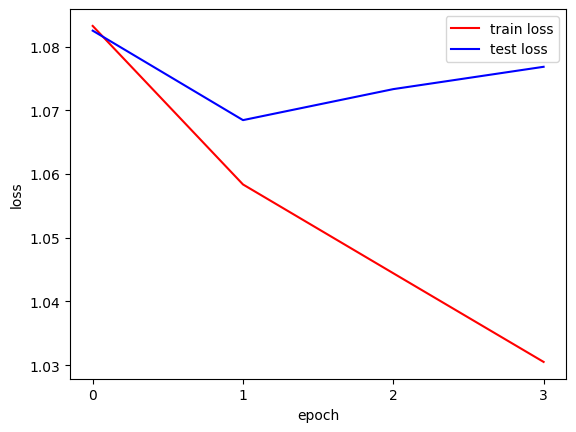

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_loss_list, color='red', label='train loss')
plt.plot(test_loss_list, color='blue', label='test loss')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.xticks(range(len(train_loss_list)))

([<matplotlib.axis.XTick at 0x789cd0e4e830>,
 [Text(0, 0, '0'), Text(1, 0, '1'), Text(2, 0, '2'), Text(3, 0, '3')])

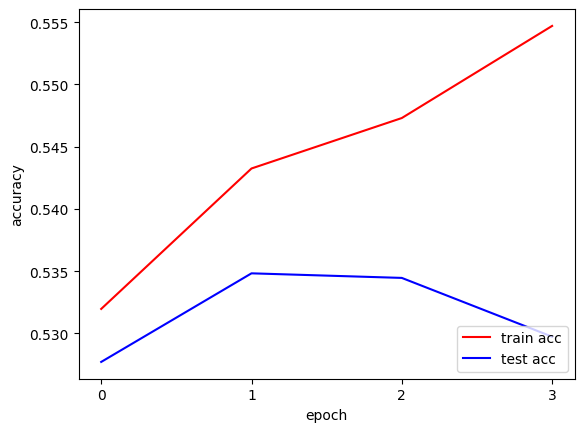

In [ ]:
plt.plot(train_acc_list, color='red', label='train acc')
plt.plot(test_acc_list, color='blue', label='test acc')
plt.legend(loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.xticks(range(len(train_loss_list)))

# Prediction

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.jit.load('/content/drive/MyDrive/project1/model_ewn.pt', device)

In [ ]:
model.eval()

board = np.array([[3, 4, 2, 0, 0]
          ,[5, 1, 0, 0, 0]
          ,[6, 0, 0, 0, 12]
          ,[0, 0, 0, 7, 10]
          ,[0, 0, 9, 8, 11]])
input = prepare_input(board, "3/c5-d4", 0)
input = torch.from_numpy(input).reshape(1, 16, 5, 5).to(device, dtype=torch.float)
output = model(input)
prob = F.softmax(output, dim=1)
torch.set_printoptions(precision=4, sci_mode=False)
prob

tensor([[    0.1022,     0.3697,     0.5281,     0.0000,     0.0000,     0.0000]],
       grad_fn=<SoftmaxBackward0>)